In [1]:
# Initialize & Establish MongoDB Connection
from pymongo import MongoClient
from pandas import DataFrame
import pandas as pd
import urllib.parse
%matplotlib inline
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
import matplotlib.pyplot as plt
import numpy as np
import json
import ast

def batched(cur, batch_size):
    batch = []
    for doc in cur:
        batch.append(doc)
        if batch and not len(batch) % batch_size:
            yield batch
            batch = []
    if batch:  
        yield batch
        
def process_query(col,query):
    cur = db[col].aggregate(query,allowDiskUse = True)

    df = pd.DataFrame()
    for batch in batched(cur, 10000):
        dfb = pd.DataFrame(list(batch))
        df = pd.concat([df, dfb])
        
    return df

mongo_host = "10.0.0.1"
mongo_port = 27017

mongo_user = "root"
mongo_pass = ""  

auth_db = "admin" 

client = MongoClient(f'mongodb://{mongo_user}:{urllib.parse.quote_plus(mongo_pass)}@{mongo_host}:{mongo_port}/{auth_db}') 
db = client.android

colist = db.list_collection_names()
print(colist)

['apps', 'manifest', 'new_man']


In [2]:
col = db.new_man
manifest = pd.DataFrame(col.find())
df = pd.json_normalize(manifest['manifest'])
df = df.replace(np. nan,'',regex=True)

In [6]:
# Debuggable
filtered = df[df['application.-debuggable'].str.contains('true', case=False, na=False) | df['-debuggable'].str.contains('true', case=False, na=False)]
result = filtered["-package"]
print(result.count())

5


In [7]:
# AllowBackup
filtered = df[df['application.-allowBackup'].str.contains('true', case=False, na=False)]
result = filtered["-package"]
print(result.count())

21285


In [8]:
# Exported

activity_filtered = df[df['application.activity.-exported'].str.contains('true', case=False, na=False)]
activity_result = activity_filtered["-package"]

receiver_filtered = df[df['application.receiver.-exported'].str.contains('true', case=False, na=False)]
receiver_result = receiver_filtered["-package"]

service_filtered = df[df['application.service.-exported'].str.contains('true', case=False, na=False)]
service_result = service_filtered["-package"]

provider_filtered = df[df['application.provider.-exported'].str.contains('true', case=False, na=False)]
provider_result = provider_filtered["-package"]

filtered = df[df.apply(lambda row: row.astype(str).str.contains("'-exported': 'true'", case=False, na=False).any(), axis=1)]
result = filtered["-package"]

print(result.count() + activity_result.count() + receiver_result.count() + service_result.count() + provider_result.count())

44799


In [9]:
# Cleartext Traffic
filtered = df[df['application.-usesCleartextTraffic'].str.contains('true', case=False, na=False)]
result = filtered["-package"]
print(result.count())

13684


In [10]:
# Protection level
filtered = df[~df['permission.-protectionLevel'].str.contains('signature', case=False, na=False)]
result = filtered["-package"]
print(result.count())


48513


In [11]:
# minSDKVersion
df_sdk = df.copy(deep=True)
df_sdk = df_sdk.fillna(0)
df_sdk['uses-sdk.-minSdkVersion'] = df_sdk['uses-sdk.-minSdkVersion'].replace('',0)
df_sdk['uses-sdk.-minSdkVersion'] = df_sdk['uses-sdk.-minSdkVersion'].astype(int)
filtered = df[df_sdk['uses-sdk.-minSdkVersion'].isin(range(15))]

result = filtered["-package"]
print(result.count())

3232


com.google.android.gms: 286
com.excean.parallelspace: 236
com.trendmicro.tmas: 236
com.excelliance.multiaccounts: 235
com.excelliance.multiaccount: 235
com.excean.parallelspace.b32: 231
com.excelliance.multiaccounts.b32: 231
com.excelliance.multiaccount.assist: 231
dual.multi.clone.apps.accounts.lnstagram.whatsapp: 231
com.samsung.android.waterplugin: 224


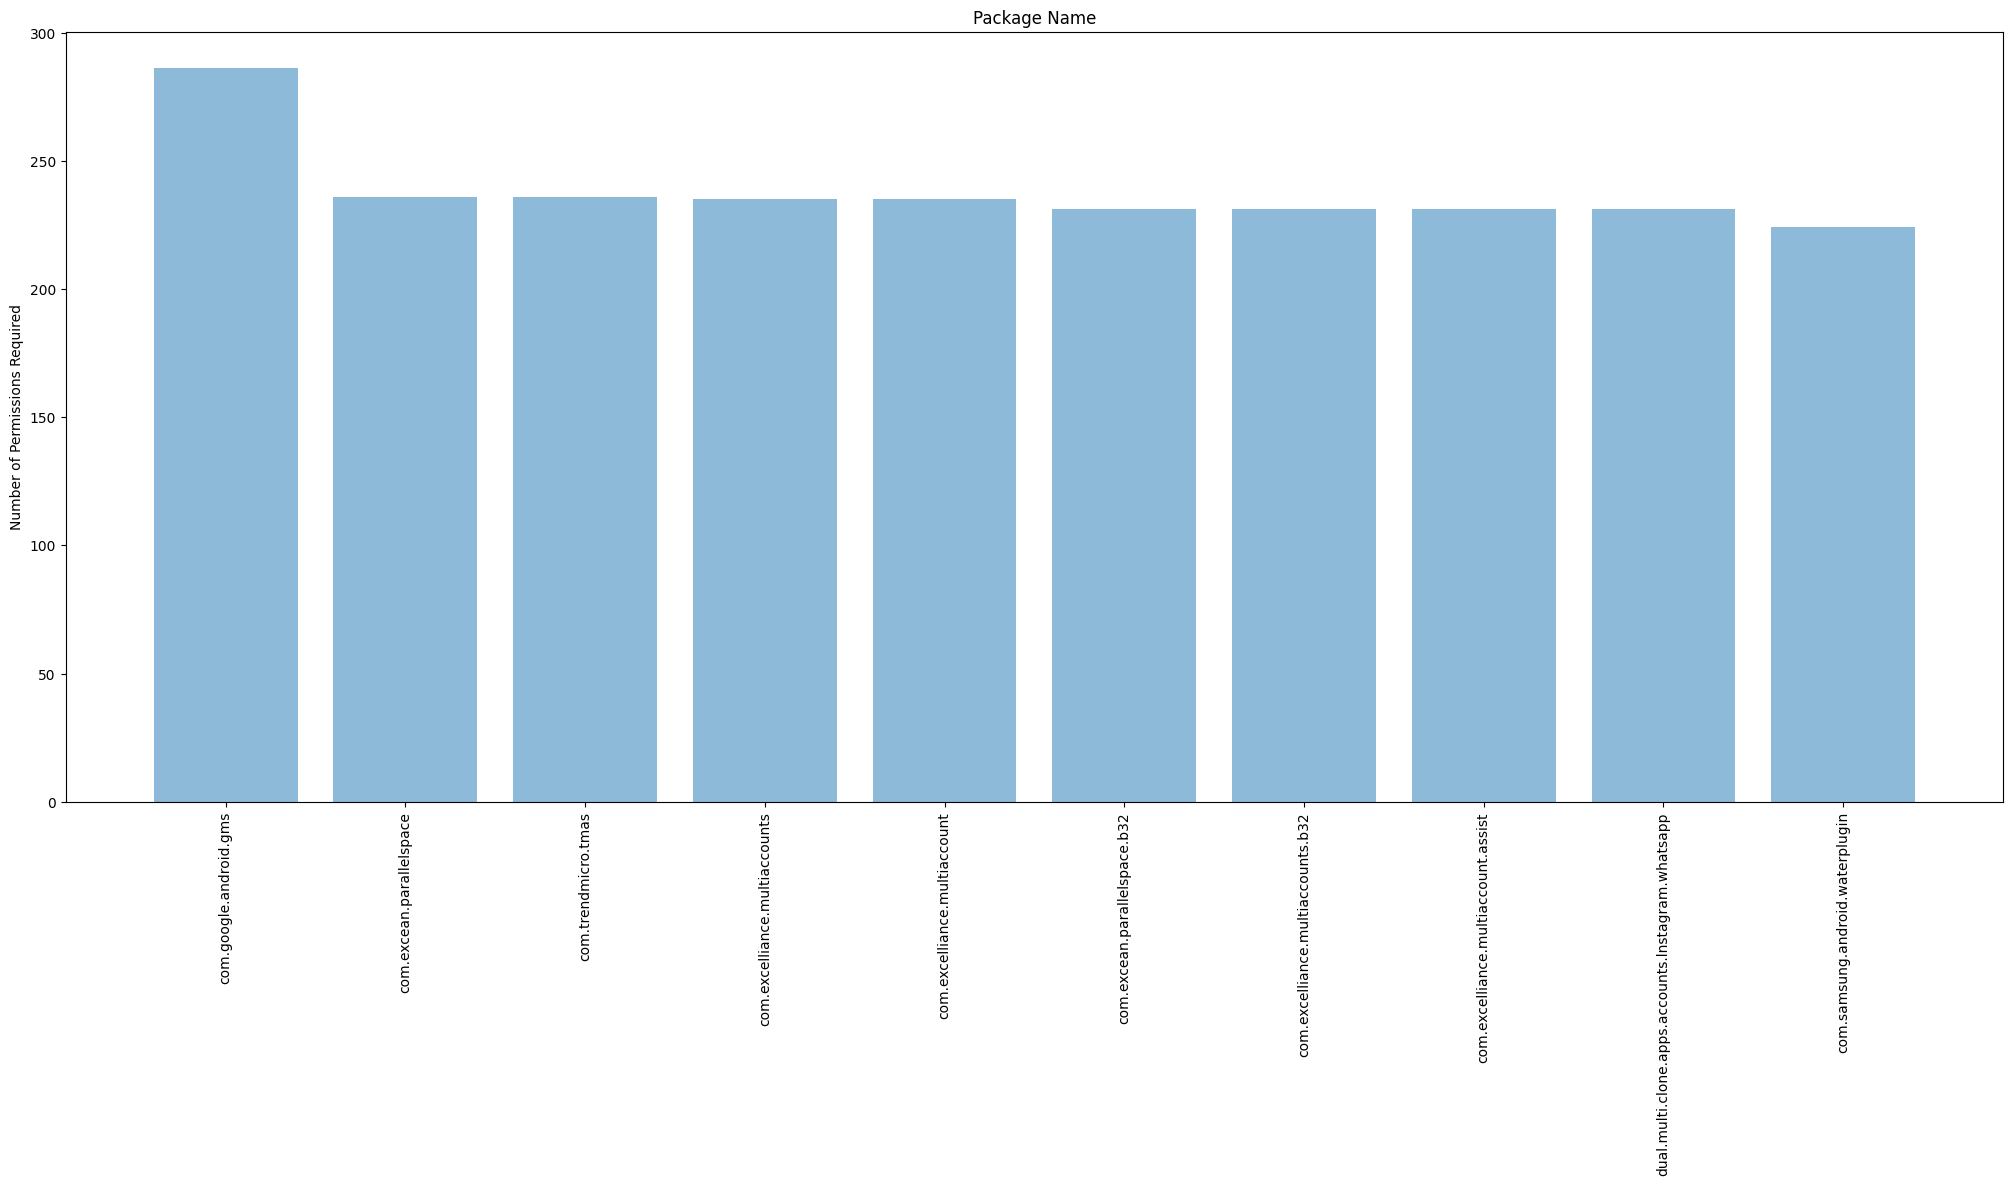

In [12]:
# Top 10 packages requiring most permissions
df_perm = df.copy(deep=True)
df_perm = df_perm.loc[:, ['-package', 'uses-permission']]
dfx = df_perm.values.tolist()
count = 0
res = []
for x in dfx:
    inner_res = [str(dfx[count][0]),len(dfx[count][1])]
    res.append(inner_res)
    count = count + 1
res = sorted(res, key=lambda x: x[1], reverse=True)
 
res_10 = res[:10]  

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10

slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number of Permissions Required')
plt.title('Package Name')

plt.show()

android.permission.WRITE_EXTERNAL_STORAGE: 27304
android.permission.READ_EXTERNAL_STORAGE: 22401
android.permission.CAMERA: 11675
android.permission.READ_PHONE_STATE: 10949
android.permission.ACCESS_COARSE_LOCATION: 10282
android.permission.ACCESS_FINE_LOCATION: 9938
android.permission.RECORD_AUDIO: 6706
android.permission.GET_ACCOUNTS: 4605
android.permission.CALL_PHONE: 2206
android.permission.WRITE_CONTACTS: 1365


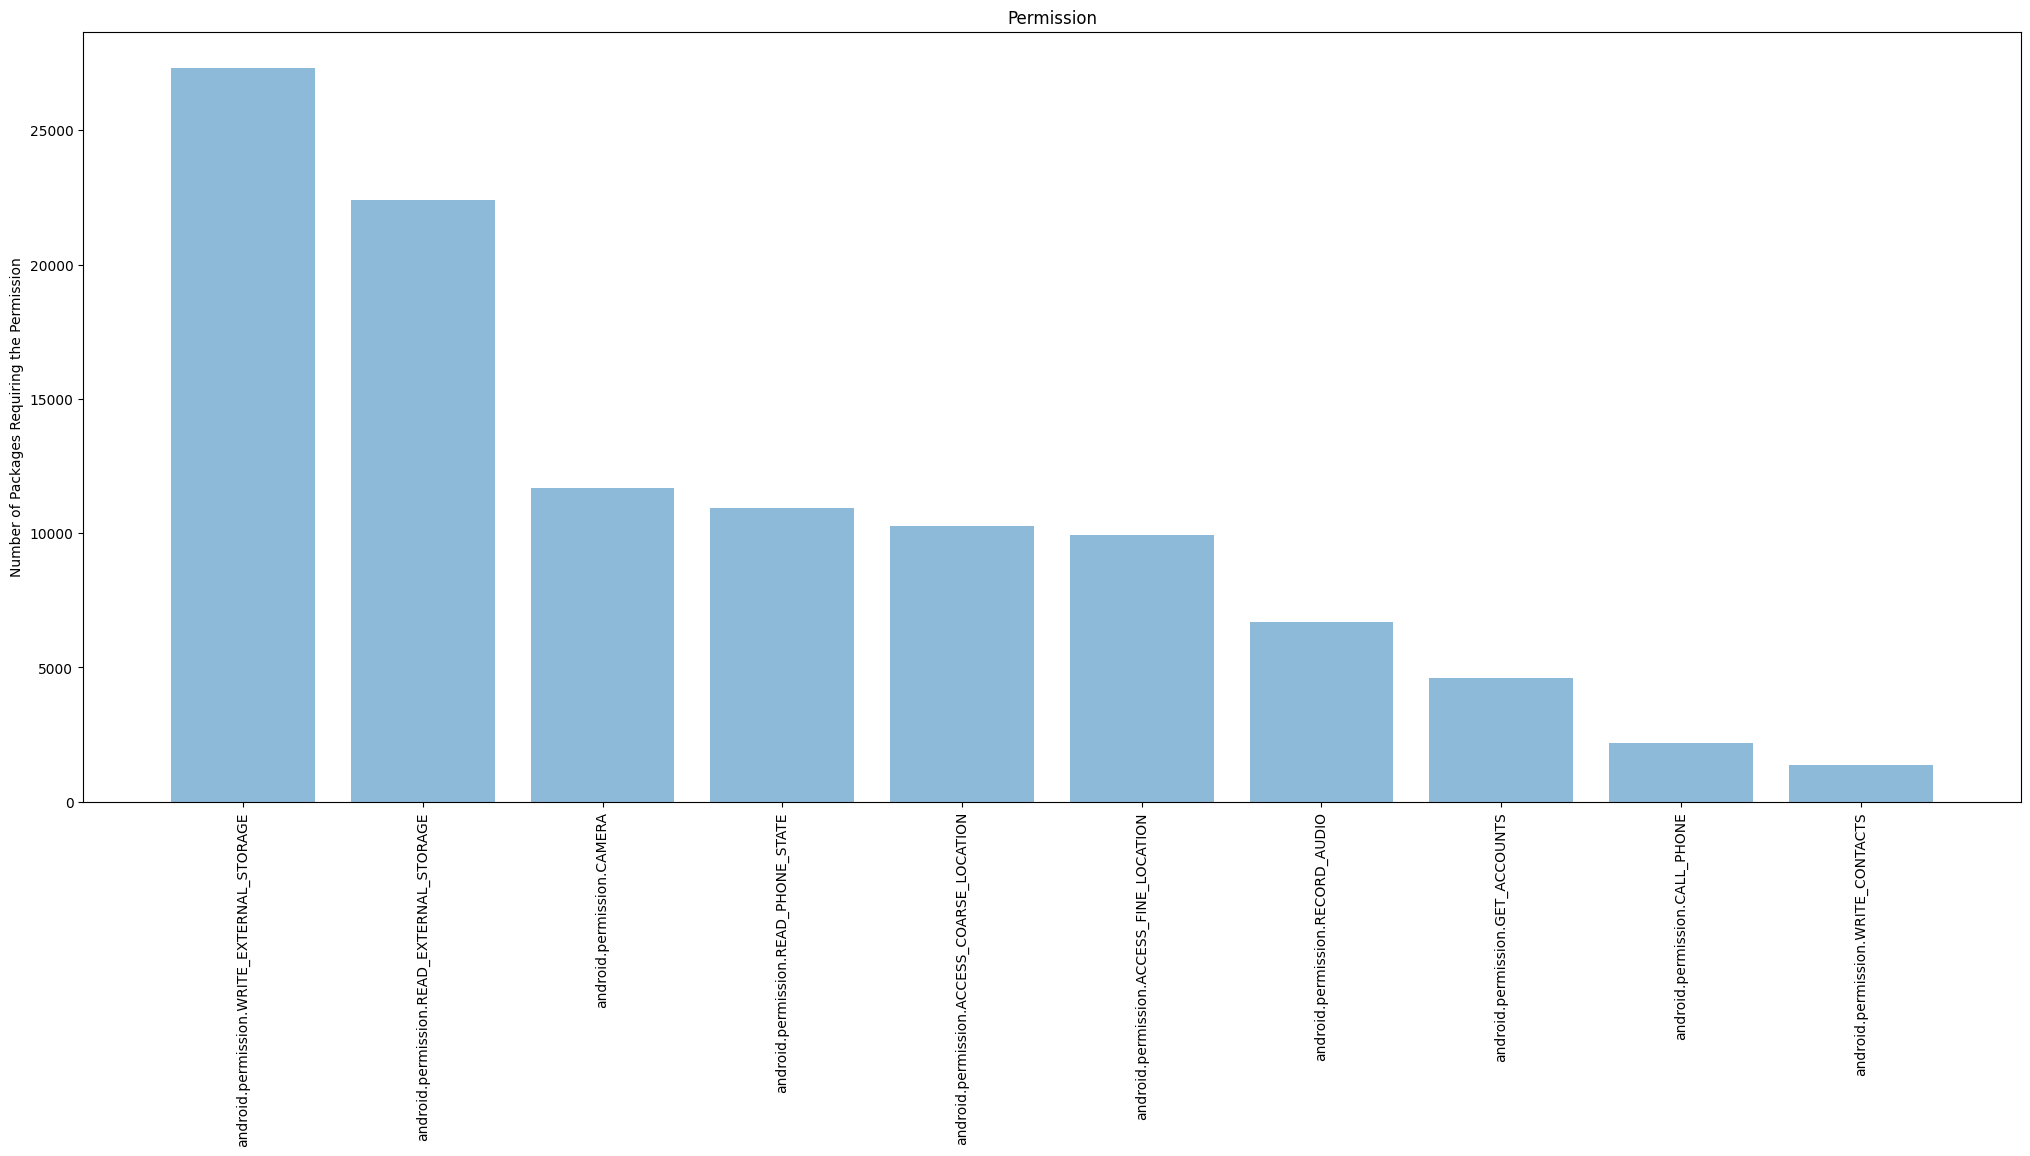

In [13]:
# Top dangerous permissions
danger_perm = ['android.permission.ACCEPT_HANDOVER','android.permission.ACCESS_BACKGROUND_LOCATION','android.permission.ACCESS_COARSE_LOCATION','android.permission.ACCESS_FINE_LOCATION','android.permission.ACCESS_MEDIA_LOCATION','android.permission.ADD_VOICEMAIL','android.permission.ANSWER_PHONE_CALLS','android.permission.BODY_SENSORS','android.permission.CALL_PHONE','android.permission.CAMERA','android.permission.GET_ACCOUNTS','android.permission.PROCESS_OUTGOING_CALLS','android.permission.READ_CALL_LOG','android.permission.READ_EXTERNAL_STORAGE','android.permission.READ_PHONE_NUMBERS','android.permission.READ_PHONE_STATE','android.permission.READ_SMS','android.permission.RECEIVE_MMS','android.permission.RECEIVE_SMS','android.permission.RECEIVE_WAP_PUSH','android.permission.RECORD_AUDIO','android.permission.SEND_SMS','android.permission.USE_SIP','android.permission.WRITE_CALL_LOG','android.permission.WRITE_CONTACTS','android.permission.WRITE_EXTERNAL_STORAGE']

dfx = df_perm
dfx["uses-permission"]=dfx["uses-permission"].astype('str')

res = []
for x in danger_perm:
    filtered = df[dfx['uses-permission'].str.contains(str(x), case=False, na=False)]
    packages = filtered["-package"]
    inner_res = [x,packages.count()]
    res.append(inner_res)
    
res = sorted(res, key=lambda x: x[1], reverse=True)

res_10 = res[:10]  

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10    

slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number of Packages Requiring the Permission')
plt.title('Permission')

plt.show()

com.sonyericsson.music: 15
com.tcl.MultiScreenInteraction_TV: 15
com.tencent.mm: 12
com.tcl.tvweishi: 11
com.sec.android.app.music: 10
com.google.android.apps.camera.services: 9
com.tcl.usercenter: 9
com.tcl.waterfall.overseas: 9
com.vzw.hss.myverizon: 9
com.delta.mobile.android: 8


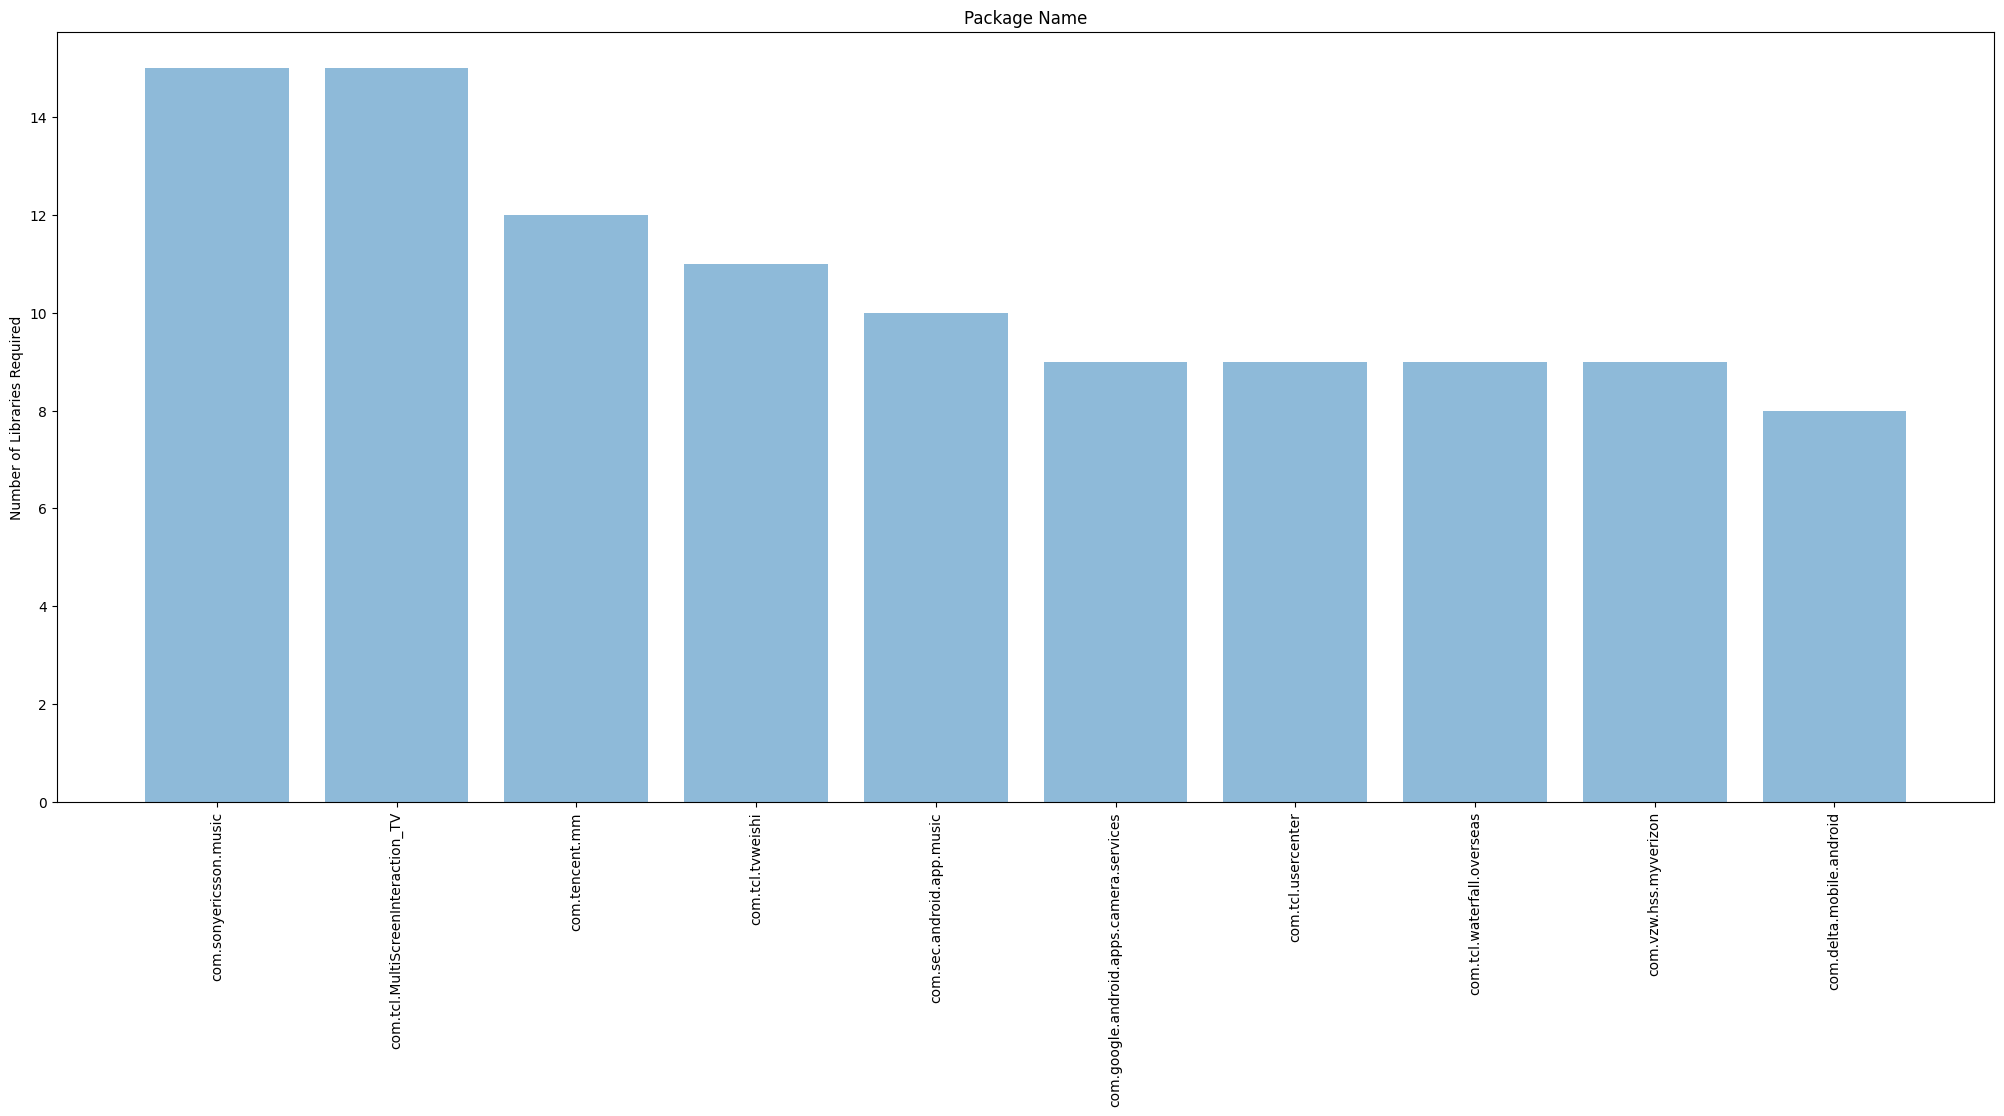

In [14]:
# Top 10 packages with most libraries
df_lib = df.copy(deep=True)
df_lib = df_lib.loc[:, ['-package', 'application.uses-library']]
dfx = df_lib.values.tolist()
count = 0
res = []
for x in dfx:
    inner_res = [str(dfx[count][0]),len(dfx[count][1])]
    res.append(inner_res)
    count = count + 1
res = sorted(res, key=lambda x: x[1], reverse=True)
 
res_10 = res[:10]  

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10    
    
slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number of Libraries Required')
plt.title('Package Name')

plt.show()

androidx.window.extensions: 6186
androidx.window.sidecar: 6186
org.apache.http.legacy: 4418
android.test.runner: 552
androidx.camera.extensions.impl: 338
android.test.base: 270
com.google.android.maps: 270
android.test.mock: 253
com.sec.android.app.multiwindow: 246
xperiaplaycertified: 73


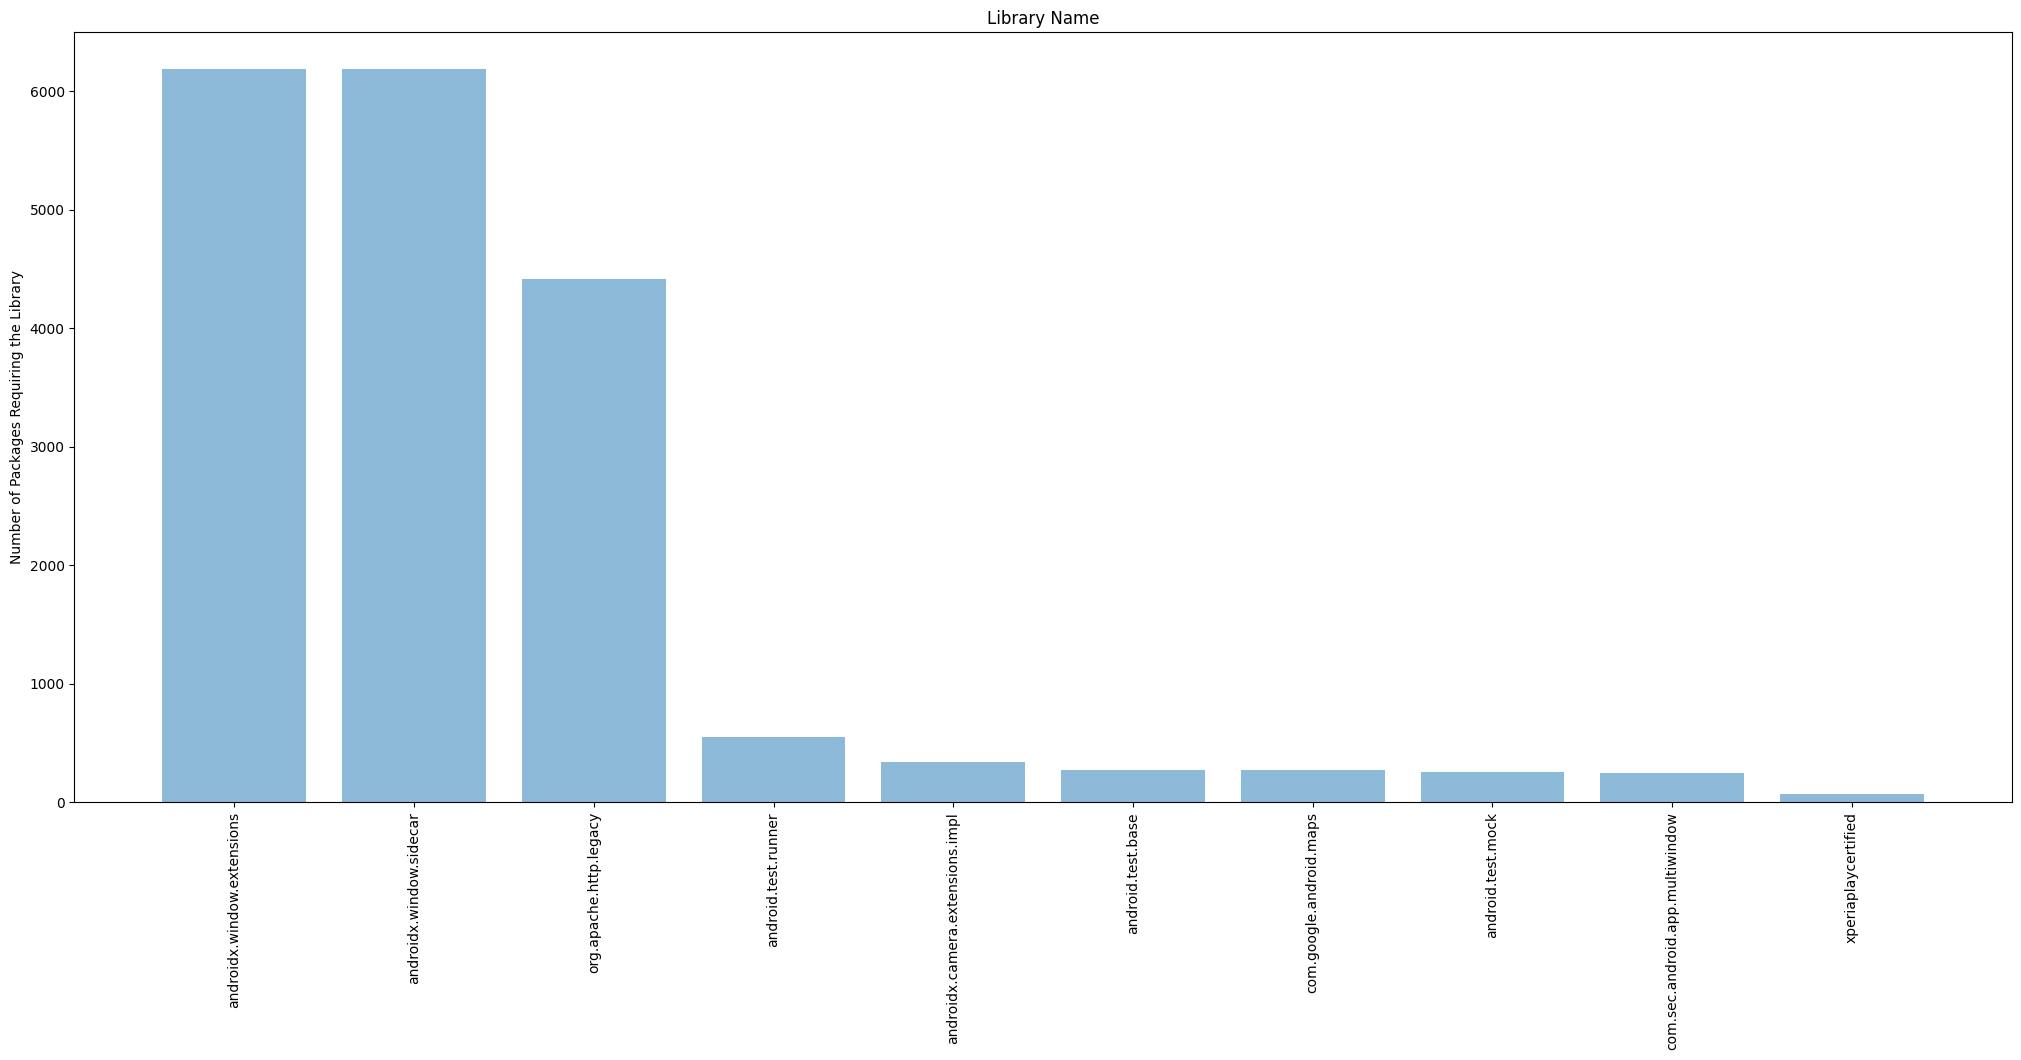

In [15]:
# Top Libraries
df_lib = df.copy(deep=True)
df_lib = df_lib['application.uses-library']
dfx = df_lib.values.tolist()
while("" in dfx):
    dfx.remove("")

res = []
x_count = 0
for x in dfx:
    y_count = 0
    for y in dfx[x_count]:
        d = dfx[x_count][y_count]
        lib = d.get('-name')
        res.append(lib)
        y_count = y_count + 1
    x_count = x_count + 1

libraries = list(dict.fromkeys(res))

df_lib = df.copy(deep=True)
df_lib = df_lib.loc[:, ['-package', 'application.uses-library']]
dfx = df_lib
dfx['application.uses-library'] = dfx['application.uses-library'].astype('str')

res = []
for x in libraries:
    filtered = df[dfx['application.uses-library'].str.contains(str(x), case=False, na=False)]
    packages = filtered["-package"]
    inner_res = [x,packages.count()]
    res.append(inner_res)
    
res = sorted(res, key=lambda x: x[1], reverse=True)

res_10 = res[:10]

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10    
    
slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number of Packages Requiring the Library')
plt.title('Library Name')

plt.show()

In [16]:
# Top Permissions
df_lib = df.copy(deep=True)
df_lib = df_lib['uses-permission']
dfx = df_lib.values.tolist()
while("" in dfx):
    dfx.remove("")

res = []
x_count = 0
for x in dfx:
    y_count = 0
    for y in dfx[x_count]:
        d = dfx[x_count][y_count]
        lib = d.get('-name')
        res.append(lib)
        y_count = y_count + 1
    x_count = x_count + 1

libraries = list(dict.fromkeys(res))

df_lib = df.copy(deep=True)
df_lib = df_lib.loc[:, ['-package', 'uses-permission']]
dfx = df_lib
dfx['uses-permission'] = dfx['uses-permission'].astype('str')

res = []
for x in libraries:
    filtered = df[dfx['uses-permission'].str.contains(str(x), case=False, na=False)]
    packages = filtered["-package"]
    inner_res = [x,packages.count()]
    res.append(inner_res)
    
res = sorted(res, key=lambda x: x[1], reverse=True)

for r in res:
    print('%s: %i' % tuple(r))

.PERMISSION: 48044
 : 48044
android.permission.: 48043
android.permission.INTERNET: 47798
INTERNET: 47798
.INTERNET: 47798
ANDROID.PERMISSION.INTERNET: 47798
Android.permission.INTERNET: 47798
android.permission.ACCESS_: 47625
.ACCESS_NETWORK_STATE: 47524
ACCESS_NETWORK_STATE: 47524
android.permission.ACCESS_NETWORK_STATE: 47522
android.permission.ACCESS_NETWOR: 47522
ANDROID.PERMISSION.ACCESS_NETWORK_STATE: 47522
android.permission.ACCESS_NETWORK: 47522
Android.permission.ACCESS_NETWORK_STATE: 47522
android.permission.access_network_state: 47522
android.permission.ACCESS_NETWORK_STAT: 47522
.WAKE_LOCK: 43214
android.permission.WAKE_LOCK: 43209
android.permission.wake_lock: 43209
com.google.: 40480
BIND_GET_INSTALL_REFERRER_SERVICE: 33602
permission.BIND_GET_INSTALL_REFERRER_SERVICE: 33601
com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE: 33600
android.permission.FOREGROUND_SERVICE: 32649
Android.permission.FOREGROUND_SERVICE: 32649
android.permission.RECEIVE: 314

Number of APIs found: 1298
com.google.android.backup.api_key: 658
com.amap.api.v2.apikey: 105
com.vivo.push.api_key: 75
com.baidu.lbsapi.API_KEY: 68
api_key: 44
spay_debug_api_key: 30
appsflyer_api_key: 19
com.snap.camerakit.api.token: 16
com.calldorado.apiToken: 15
net.singular.api_key: 15


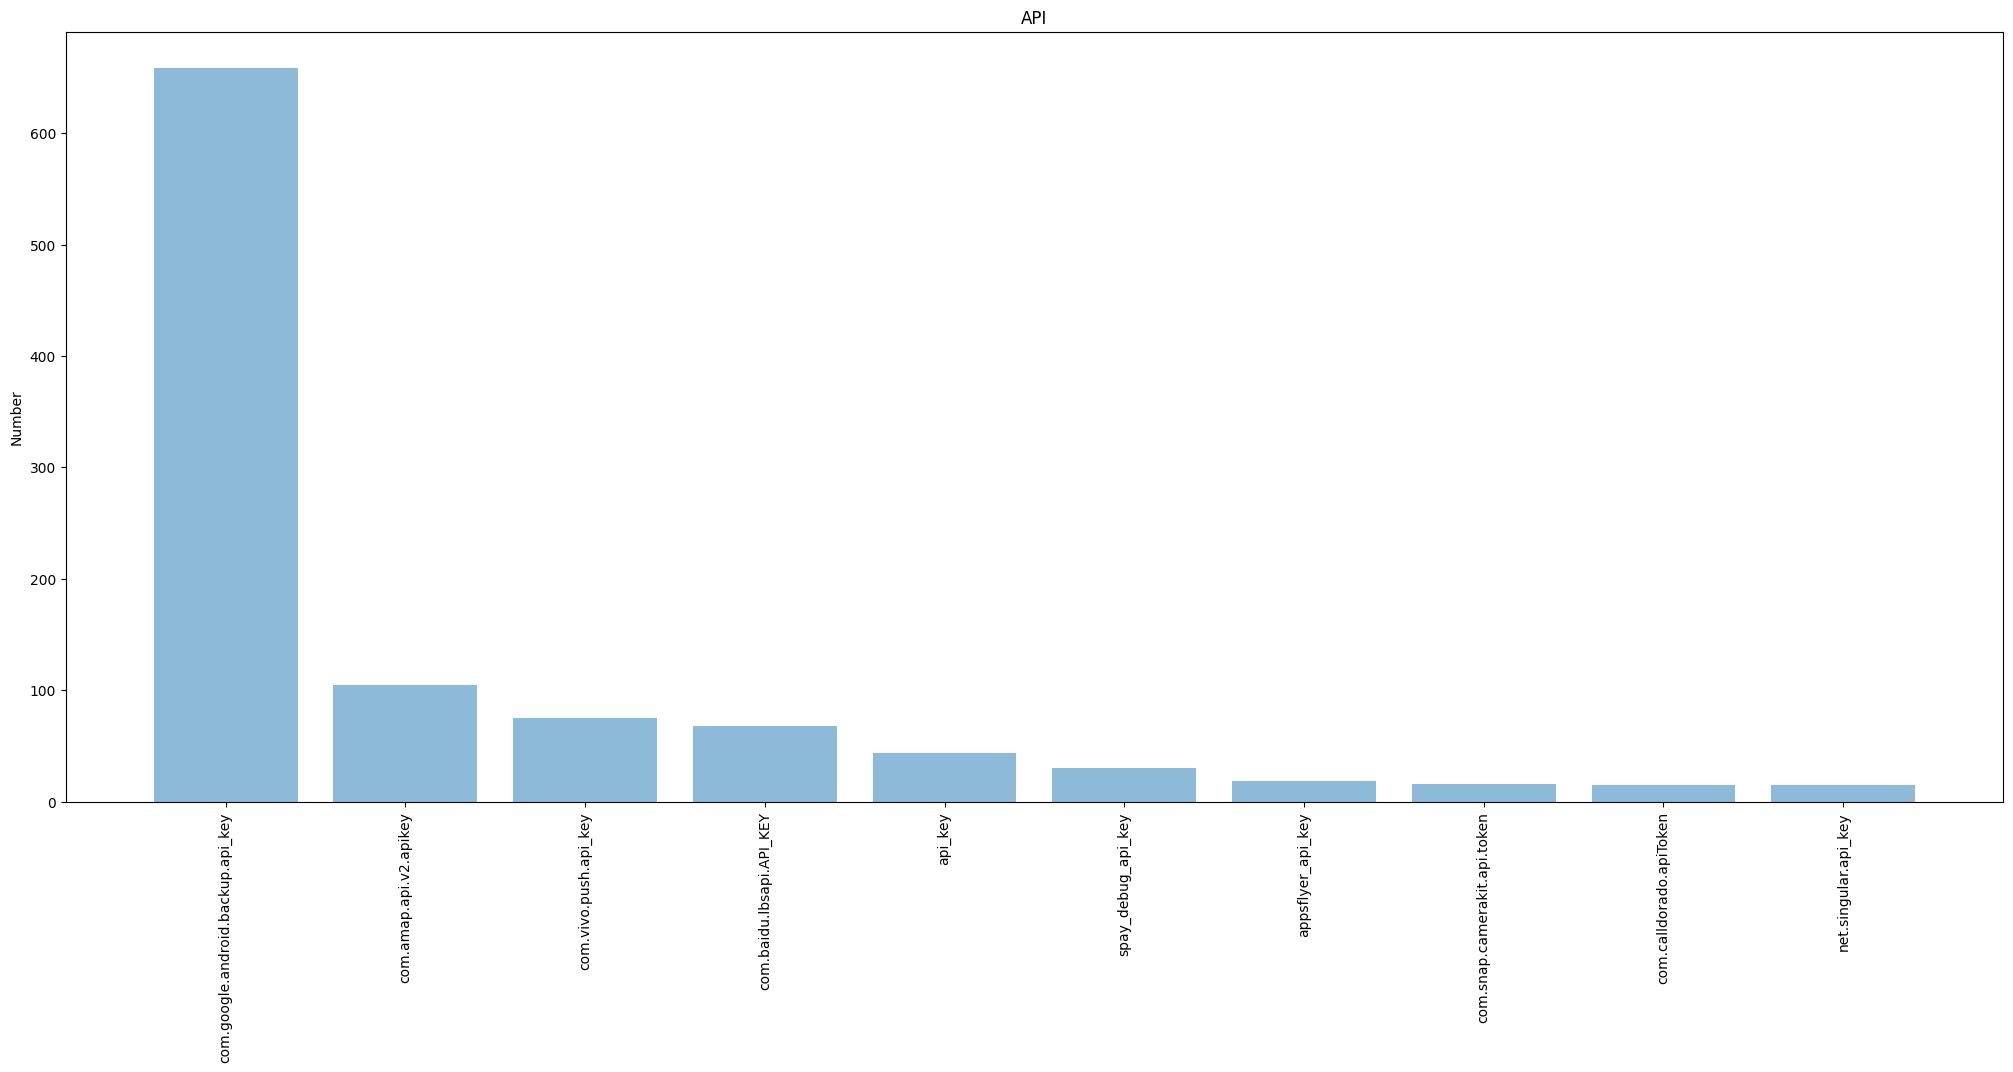

In [17]:
# Top 10 APIs

df = pd.read_csv('/root/files/apis.csv', on_bad_lines='skip')


df_apis = df.copy(deep=True)
df_apis = df[df_apis['key'].str.contains(str('key'), case=False, na=False) | df_apis['key'].str.contains(str('token'), case=False, na=False) | df_apis['key'].str.contains(str('secret'), case=False, na=False)]
df_apis = df_apis.dropna()


print("Number of APIs found: " + str(df_apis.count()[1]))

print("============================")

df_apis = df_apis['key']
dfx = df_apis.values.tolist()
while("" in dfx):
    dfx.remove("")

apis = [*set(dfx)]

df_apis = df.copy(deep=True)
df_apis = df_apis.loc[:, ['key', 'value']]
dfx = df_apis

res = []
for x in apis:
    filtered = df[dfx['key'] == str(x)]
    y = filtered["value"]
    inner_res = [x,y.count()]
    res.append(inner_res)
    
res = sorted(res, key=lambda x: x[1], reverse=True)

res_10 = res[:10]

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10    
    
slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number')
plt.title('API')

plt.show()

Number of Secrets found: 216
google.client.secret: 24
com.garena.sdk.twitter.secret: 17
com.alibaba.app.appsecret: 17
com.twitter.sdk.secret: 15
avatye_appsecret: 13
com.here.sdk.access_key_secret: 9
com.movile.faster.sdk.application_secret: 7
aws.rekognition.secretKey: 5
gateway_secret_online: 4
gateway_secret_test: 4


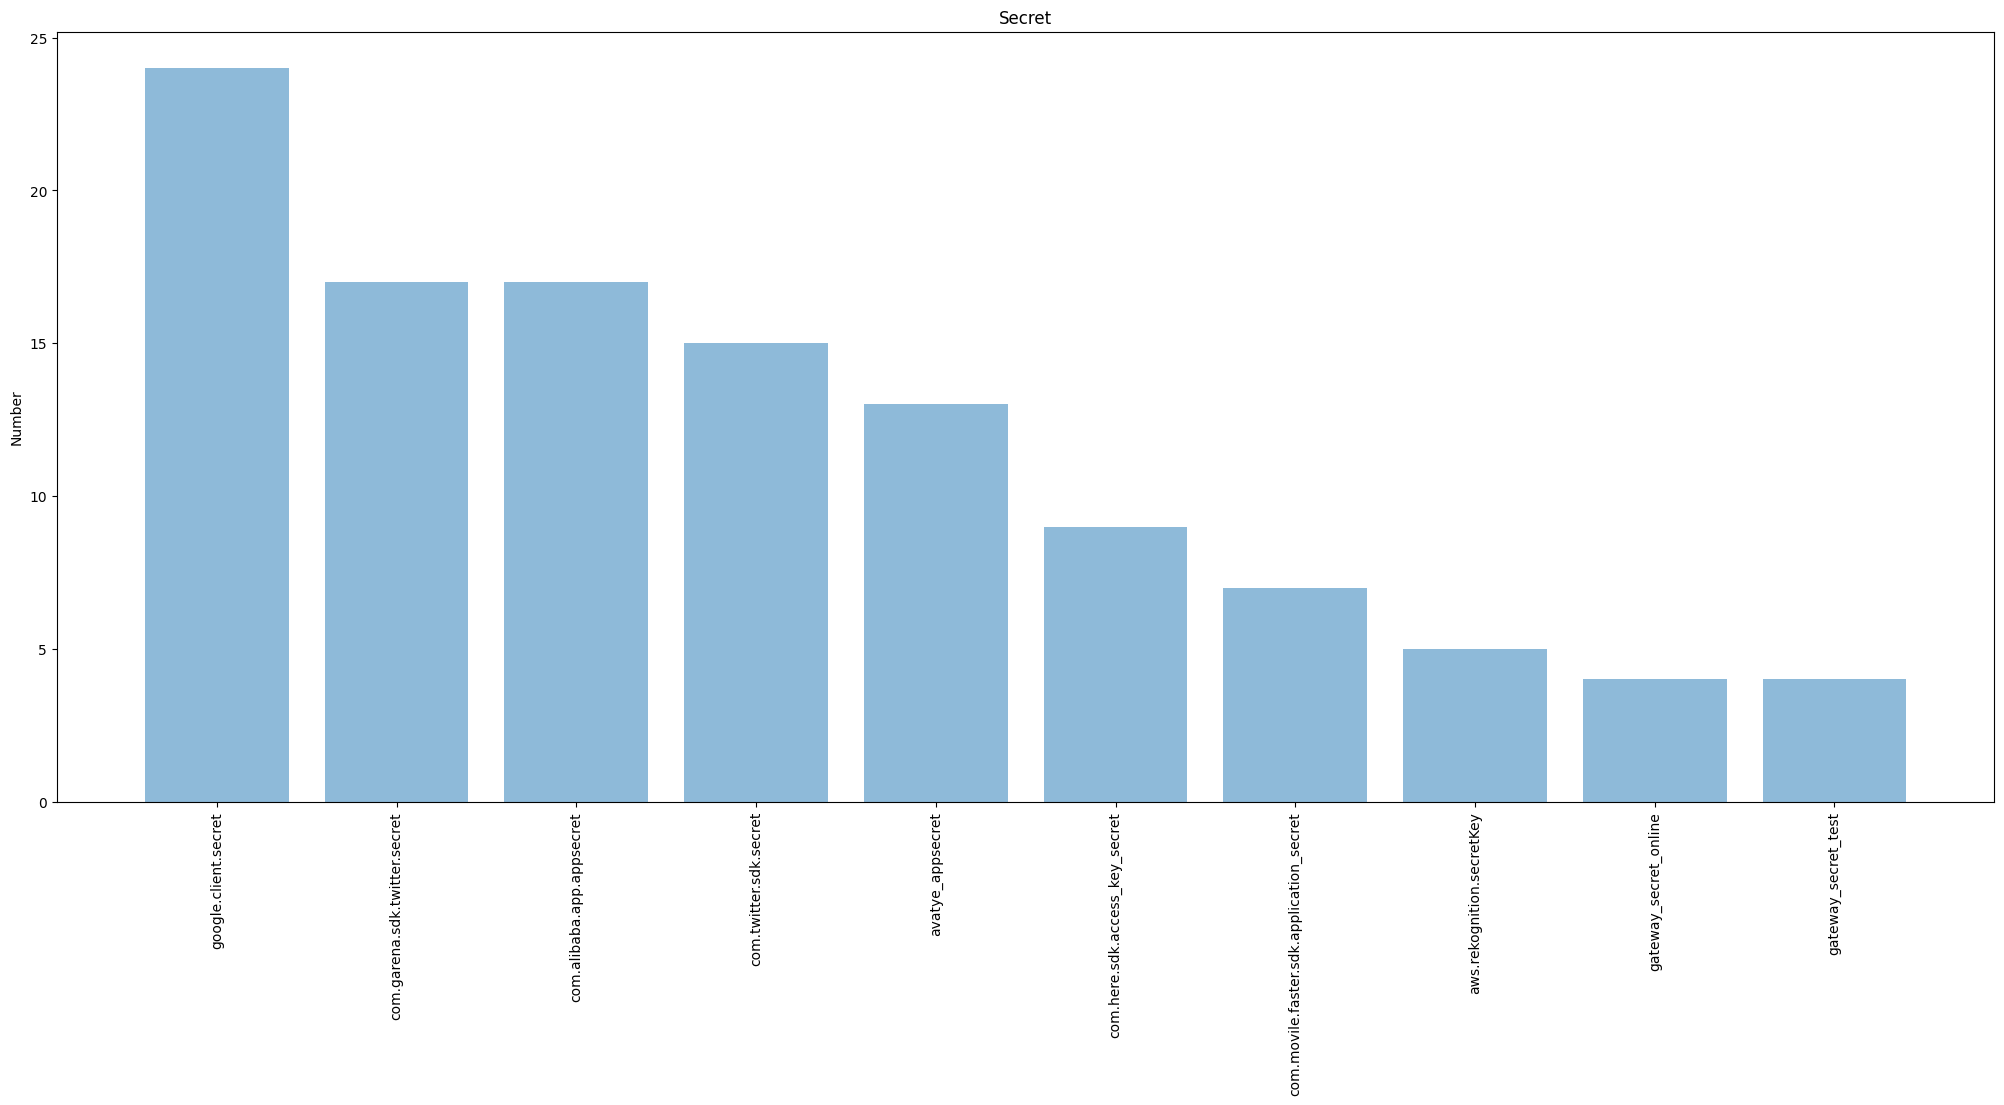

In [18]:
# Top 10 Secrets
df = pd.read_csv('/root/files/secrets.csv', on_bad_lines='skip')

df_secrets = df.copy(deep=True)
df_secrets = df[~df_secrets['key'].str.contains(str('api'), case=False, na=False)]
df_secrets = df_secrets.dropna()

print("Number of Secrets found: " + str(df_secrets.count()[1]))

print("============================")

df_secrets = df_secrets['key']
dfx = df_secrets.values.tolist()
while("" in dfx):
    dfx.remove("")

secrets = [*set(dfx)]

df_secrets = df.copy(deep=True)
df_secrets = df_secrets.loc[:, ['key', 'value']]
dfx = df_secrets

res = []
for x in secrets:
    filtered = df[dfx['key'] == str(x)]
    y = filtered["value"]
    inner_res = [x,y.count()]
    res.append(inner_res)
    
res = sorted(res, key=lambda x: x[1], reverse=True)

res_10 = res[:10]

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10    
    
slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number')
plt.title('Secret')

plt.show()

Number of Keys found: 7789
applovin.sdk.key: 5984
and_aiolos_google_appkey: 157
and_aiolos_appkey: 156
igaworks_hash_key: 98
igaworks_app_key: 95
AppsFlyerLib_key: 49
adpopcorn_ssp_app_key: 38
trackingio_app_key: 38
presage_key: 36
adpopcorn_app_key: 36


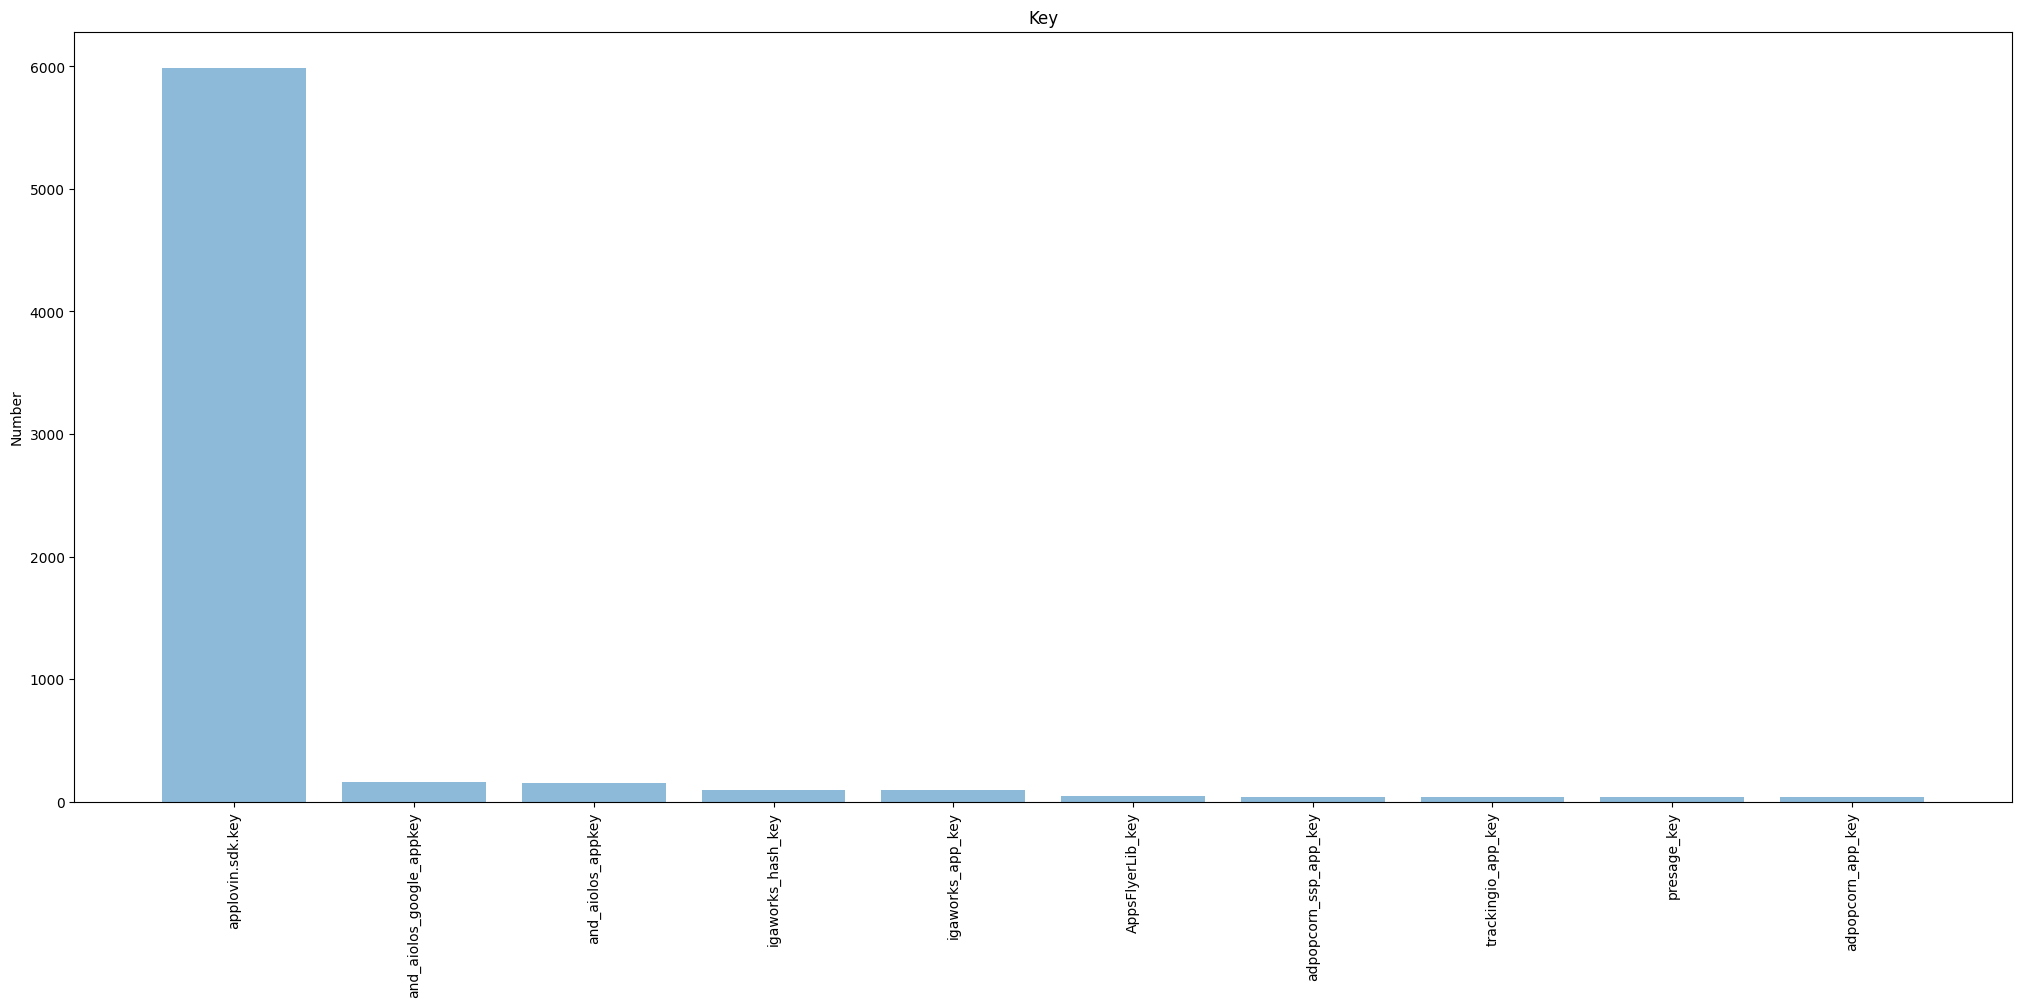

In [19]:
# Top 10 Keys
df = pd.read_csv('/root/files/keys.csv', on_bad_lines='skip')

df_keys = df.copy(deep=True)
df_keys = df[~df_keys['key'].str.contains(str('api'), case=False, na=False) & ~df_keys['key'].str.contains(str('secret'), case=False, na=False) & ~df_keys['key'].str.contains(str('monkey'), case=False, na=False) & ~df_keys['key'].str.contains(str('hockey'), case=False, na=False)]
df_keys = df_keys.dropna()

print("Number of Keys found: " + str(df_keys.count()[1]))

print("============================")

df_keys = df_keys['key']
dfx = df_keys.values.tolist()
while("" in dfx):
    dfx.remove("")

keys = [*set(dfx)]

df_keys = df.copy(deep=True)
df_keys = df_keys.loc[:, ['key', 'value']]
dfx = df_keys

res = []
for x in keys:
    filtered = df[dfx['key'] == str(x)]
    y = filtered["value"]
    inner_res = [x,y.count()]
    res.append(inner_res)
    
res = sorted(res, key=lambda x: x[1], reverse=True)

res_10 = res[:10]

for r in res_10:
    print('%s: %i' % tuple(r))

res = res_10    
    
slp = list(f[0] for f in res)
sln = list(f[1] for f in res)
y_pos = np.arange(len(res))
plt.figure(figsize=(25,10))
plt.bar(y_pos, sln, align='center', alpha=0.5)
plt.xticks(y_pos, slp, rotation='vertical')
plt.ylabel('Number')
plt.title('Key')

plt.show()